# Project for CS5296
## House Price Prediction Using PySpark
### Group 10

In [1]:
!pip install pyspark==3.5.1

In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


from pyspark.ml.regression import LinearRegression,RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed


In [5]:
# creating spark
spark = SparkSession.builder.master("local[2]").appName("California-Housing").getOrCreate()

24/04/27 16:55:39 WARN Utils: Your hostname, SennikodeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.31.133 instead (on interface en0)
24/04/27 16:55:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/27 16:55:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/27 16:55:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
spark

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=California-Housing>

In [8]:
HOUSING_DATA = 'cal_housing/CaliforniaHousing/cal_housing.data'

In [9]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [10]:
# Load housing data
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()

In [11]:
# Show first five rows
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [12]:
# show the dataframe columns
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [13]:
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



In [14]:
# run a sample selection
housing_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



In [15]:
# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

In [16]:
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



<Axes: xlabel='medage'>

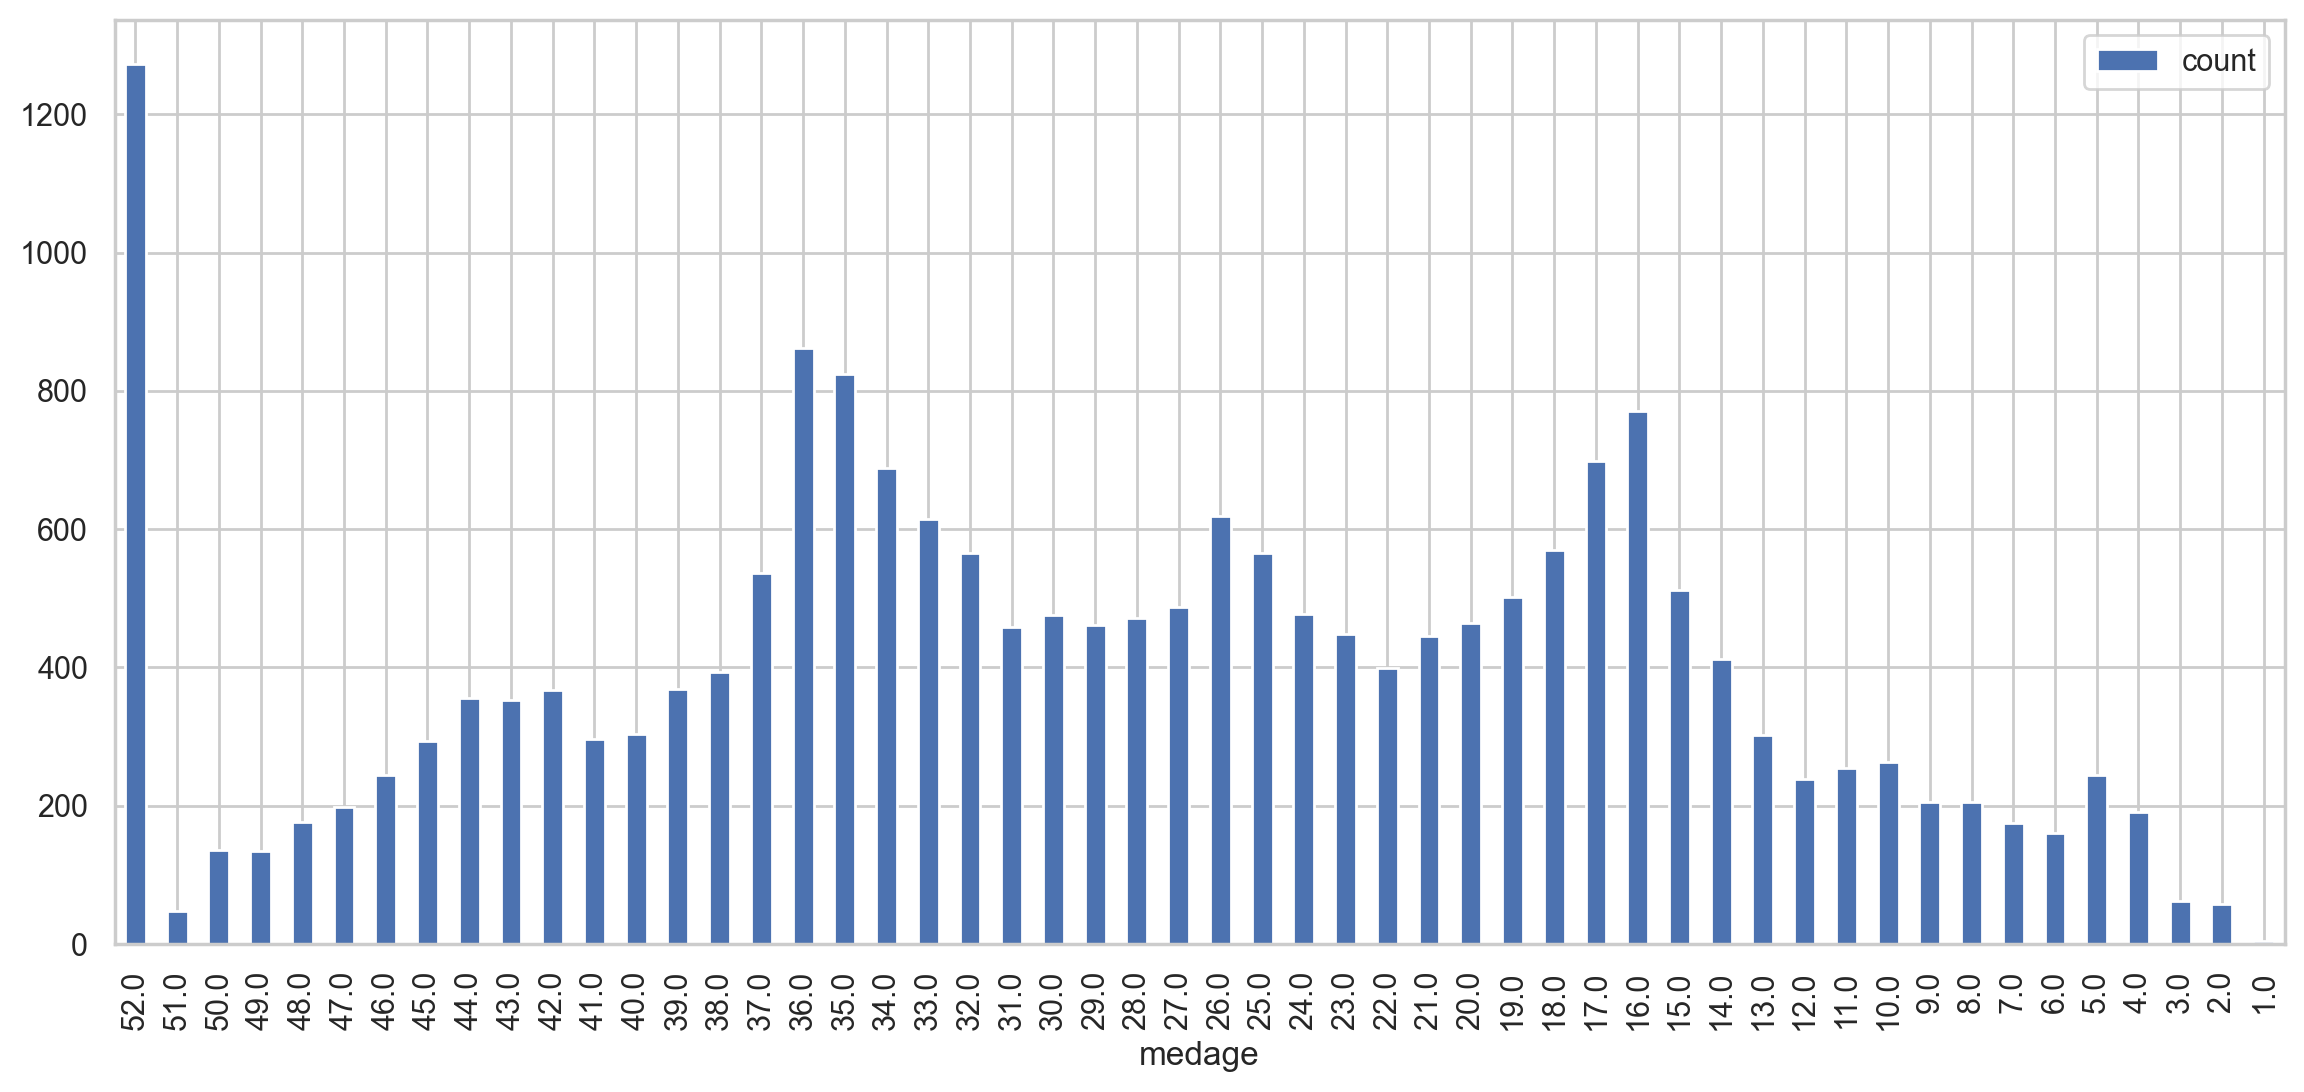

In [17]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

In [18]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

24/04/27 16:55:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



In [19]:
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [20]:
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



In [21]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [22]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [23]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



Text(0.5, 0, 'long')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'long vs MedHV')

Text(0.5, 0, 'lat')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'lat vs MedHV')

Text(0.5, 0, 'medage')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'medage vs MedHV')

Text(0.5, 0, 'totrooms')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'totrooms vs MedHV')

Text(0.5, 0, 'totbdrms')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'totbdrms vs MedHV')

Text(0.5, 0, 'pop')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'pop vs MedHV')

Text(0.5, 0, 'houshlds')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'houshlds vs MedHV')

Text(0.5, 0, 'medinc')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'medinc vs MedHV')

Text(0.5, 0, 'rmsperhh')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'rmsperhh vs MedHV')

Text(0.5, 0, 'popperhh')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'popperhh vs MedHV')

Text(0.5, 0, 'bdrmsperrm')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'bdrmsperrm vs MedHV')

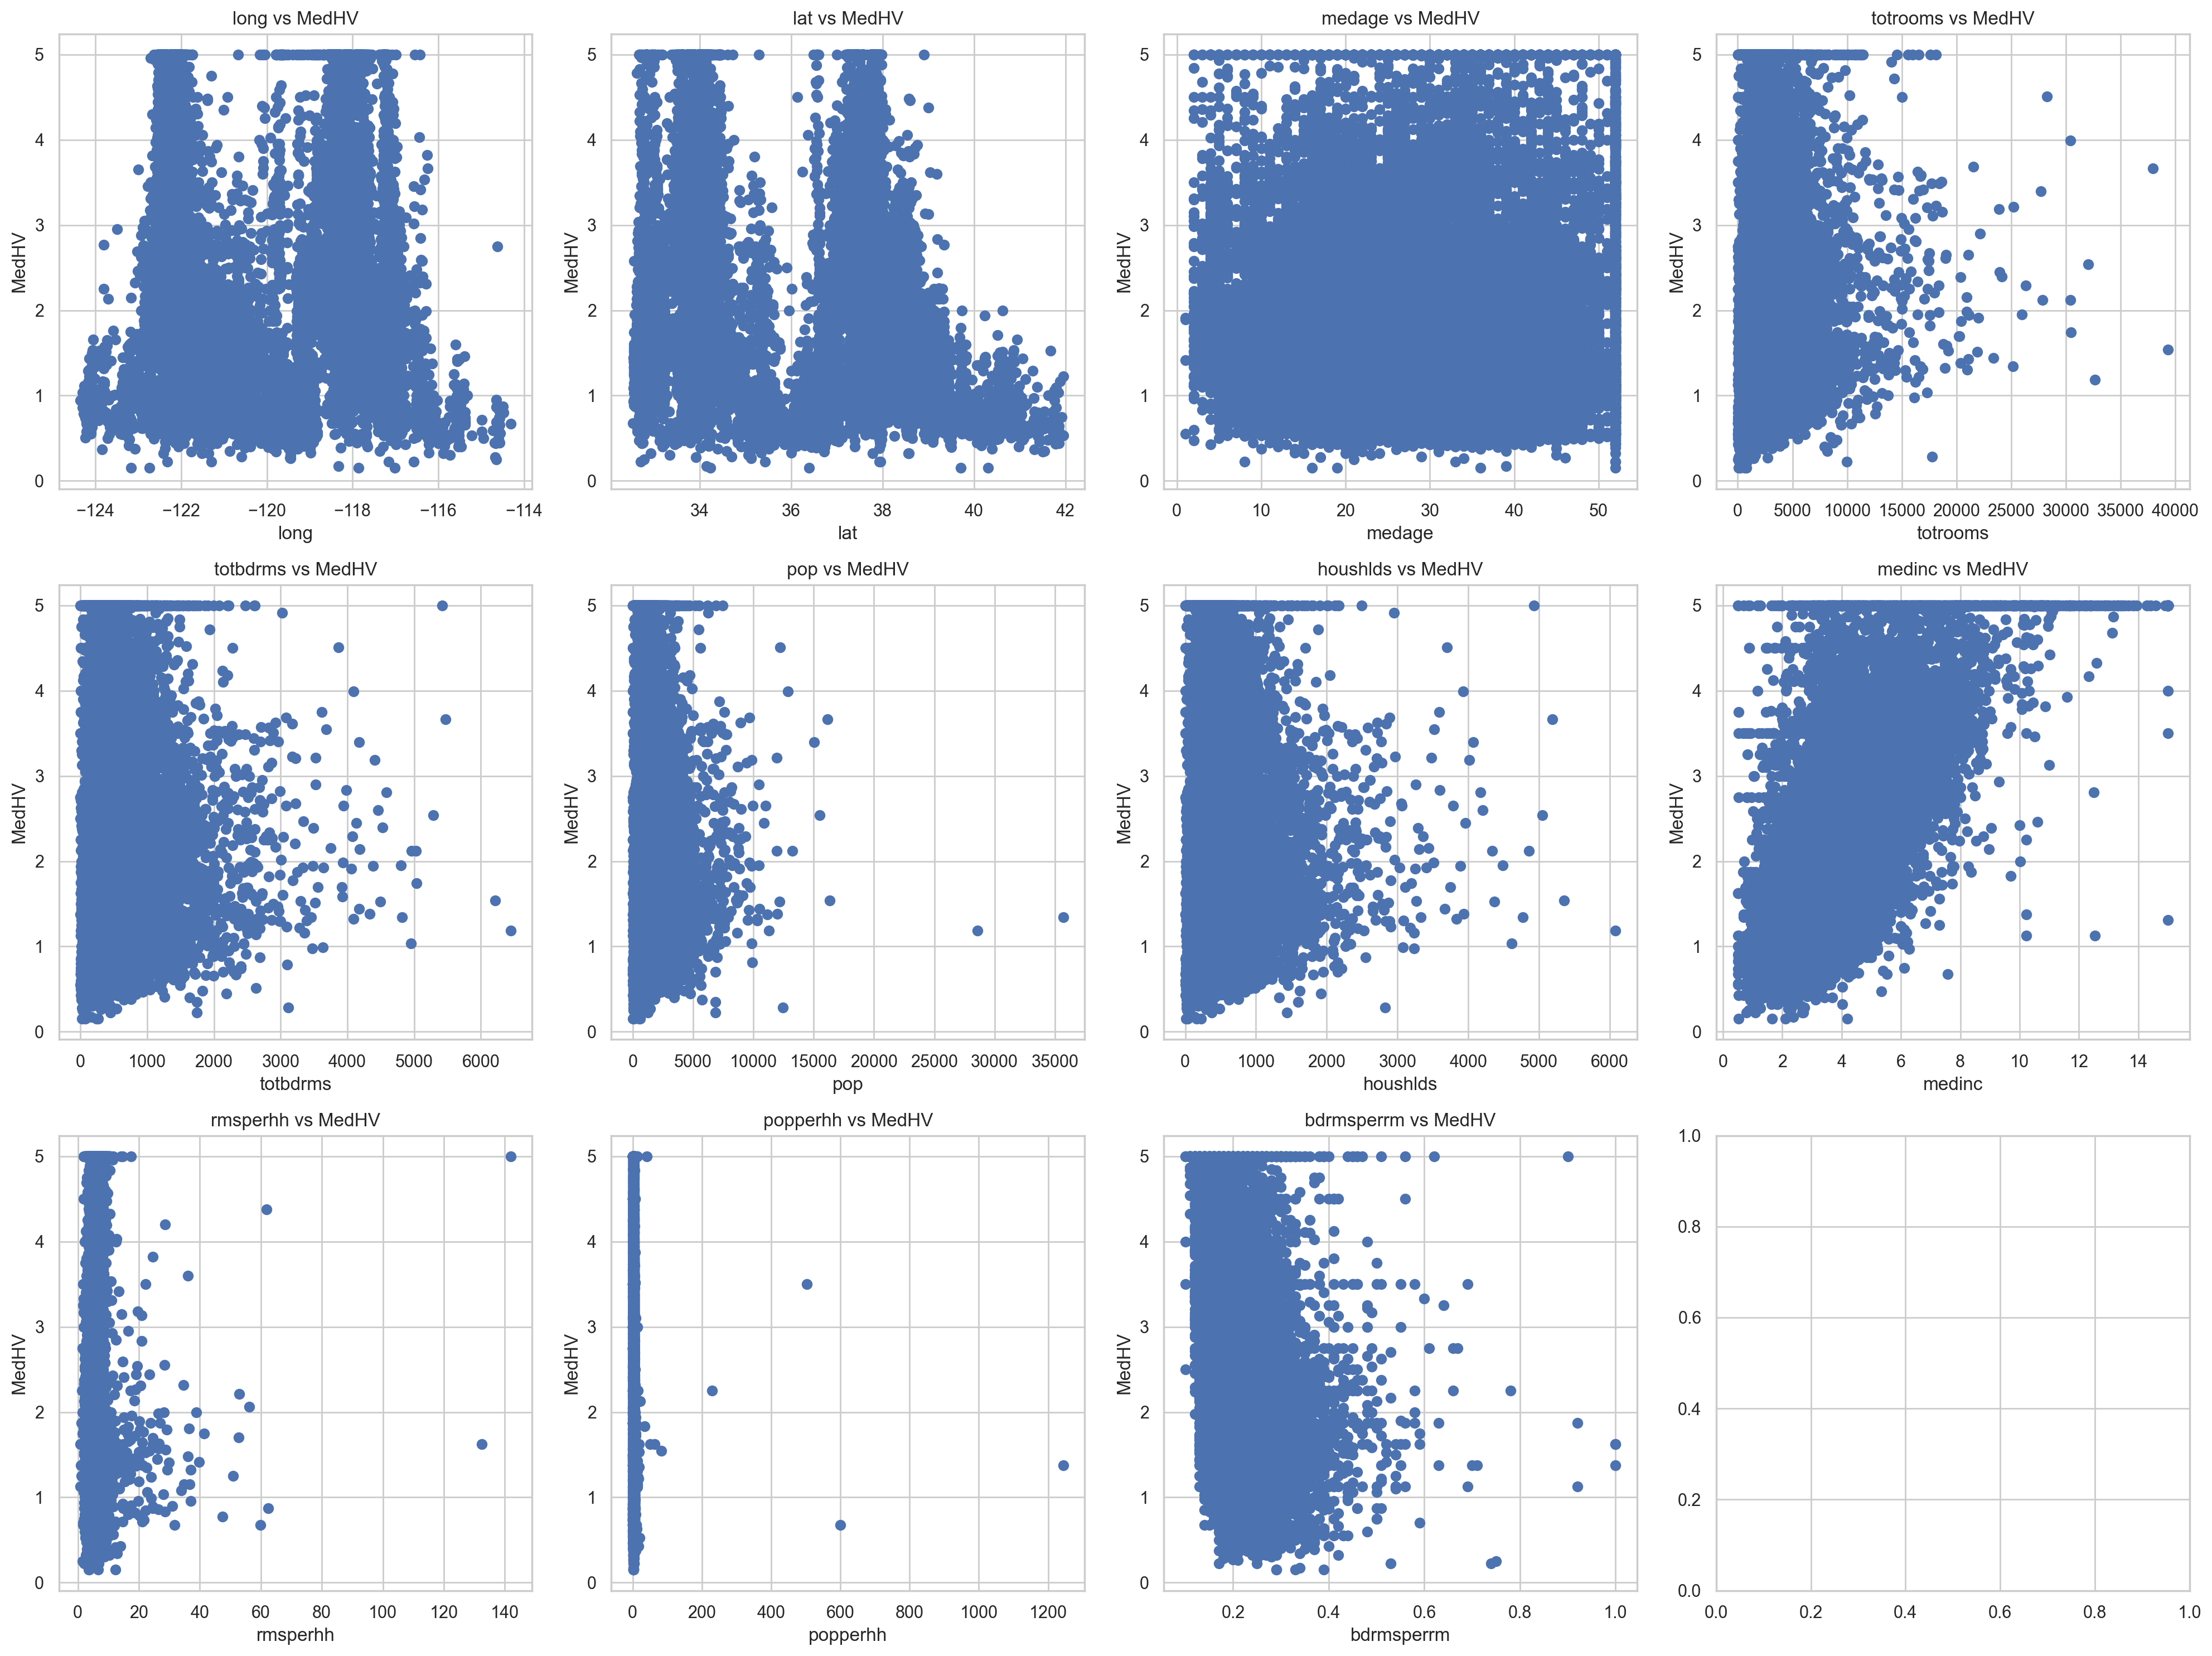

In [24]:
features = ['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']
pandas_df = housing_df.toPandas()
fig, axes = plt.subplots(3, 4, figsize=(20, 15))


for i, feature in enumerate(features):

    row = i // 4
    col = i % 4
    

    axes[row, col].scatter(pandas_df[feature], pandas_df['medhv'])
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('MedHV')
    axes[row, col].set_title(f'{feature} vs MedHV')


plt.tight_layout()


plt.show()

In [25]:
# data cleaning
from pyspark.sql.functions import col,mean,stddev
from functools import reduce

# Calculate the mean and standard deviation for each column in the housing dataframe
# Use the agg function to perform an aggregation operation which returns a single row per group
# Alias the mean as 'column_name_mean' and standard deviation as 'column_name_std' for each column
column_stats = housing_df.agg(*[
    mean(col).alias(col + '_mean') for col in housing_df.columns
] + [
    stddev(col).alias(col + '_std') for col in housing_df.columns
]).collect()[0]

# Extract the mean and standard deviation values into dictionaries for easy access
# The keys are the column names and the values are the corresponding mean or standard deviation
column_means = {col: column_stats[col + '_mean'] for col in housing_df.columns}
column_stds = {col: column_stats[col + '_std'] for col in housing_df.columns}

# Construct filter expressions for each column based on the 3-sigma rule
# This rule states that in a normal distribution, data points within three standard deviations from the mean are considered normal
# The filter expressions are created such that each column's values must be within three standard deviations from the mean
filter_expr = [
    (col(col_name) > column_means[col_name] - 3 * column_stds[col_name]) & 
    (col(col_name) < column_means[col_name] + 3 * column_stds[col_name])
    for col_name in housing_df.columns
]

# Apply the filter expressions to the housing dataframe to remove outliers
# Use the reduce function with a lambda to combine all filter expressions with an AND operator
# The result is a DataFrame with rows that pass all the filter conditions
filtered_df = housing_df.filter(
    reduce(lambda a, b: a & b, filter_expr)
)

Text(0.5, 0, 'long')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'long vs MedHV')

Text(0.5, 0, 'lat')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'lat vs MedHV')

Text(0.5, 0, 'medage')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'medage vs MedHV')

Text(0.5, 0, 'totrooms')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'totrooms vs MedHV')

Text(0.5, 0, 'totbdrms')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'totbdrms vs MedHV')

Text(0.5, 0, 'pop')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'pop vs MedHV')

Text(0.5, 0, 'houshlds')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'houshlds vs MedHV')

Text(0.5, 0, 'medinc')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'medinc vs MedHV')

Text(0.5, 0, 'rmsperhh')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'rmsperhh vs MedHV')

Text(0.5, 0, 'popperhh')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'popperhh vs MedHV')

Text(0.5, 0, 'bdrmsperrm')

Text(0, 0.5, 'MedHV')

Text(0.5, 1.0, 'bdrmsperrm vs MedHV')

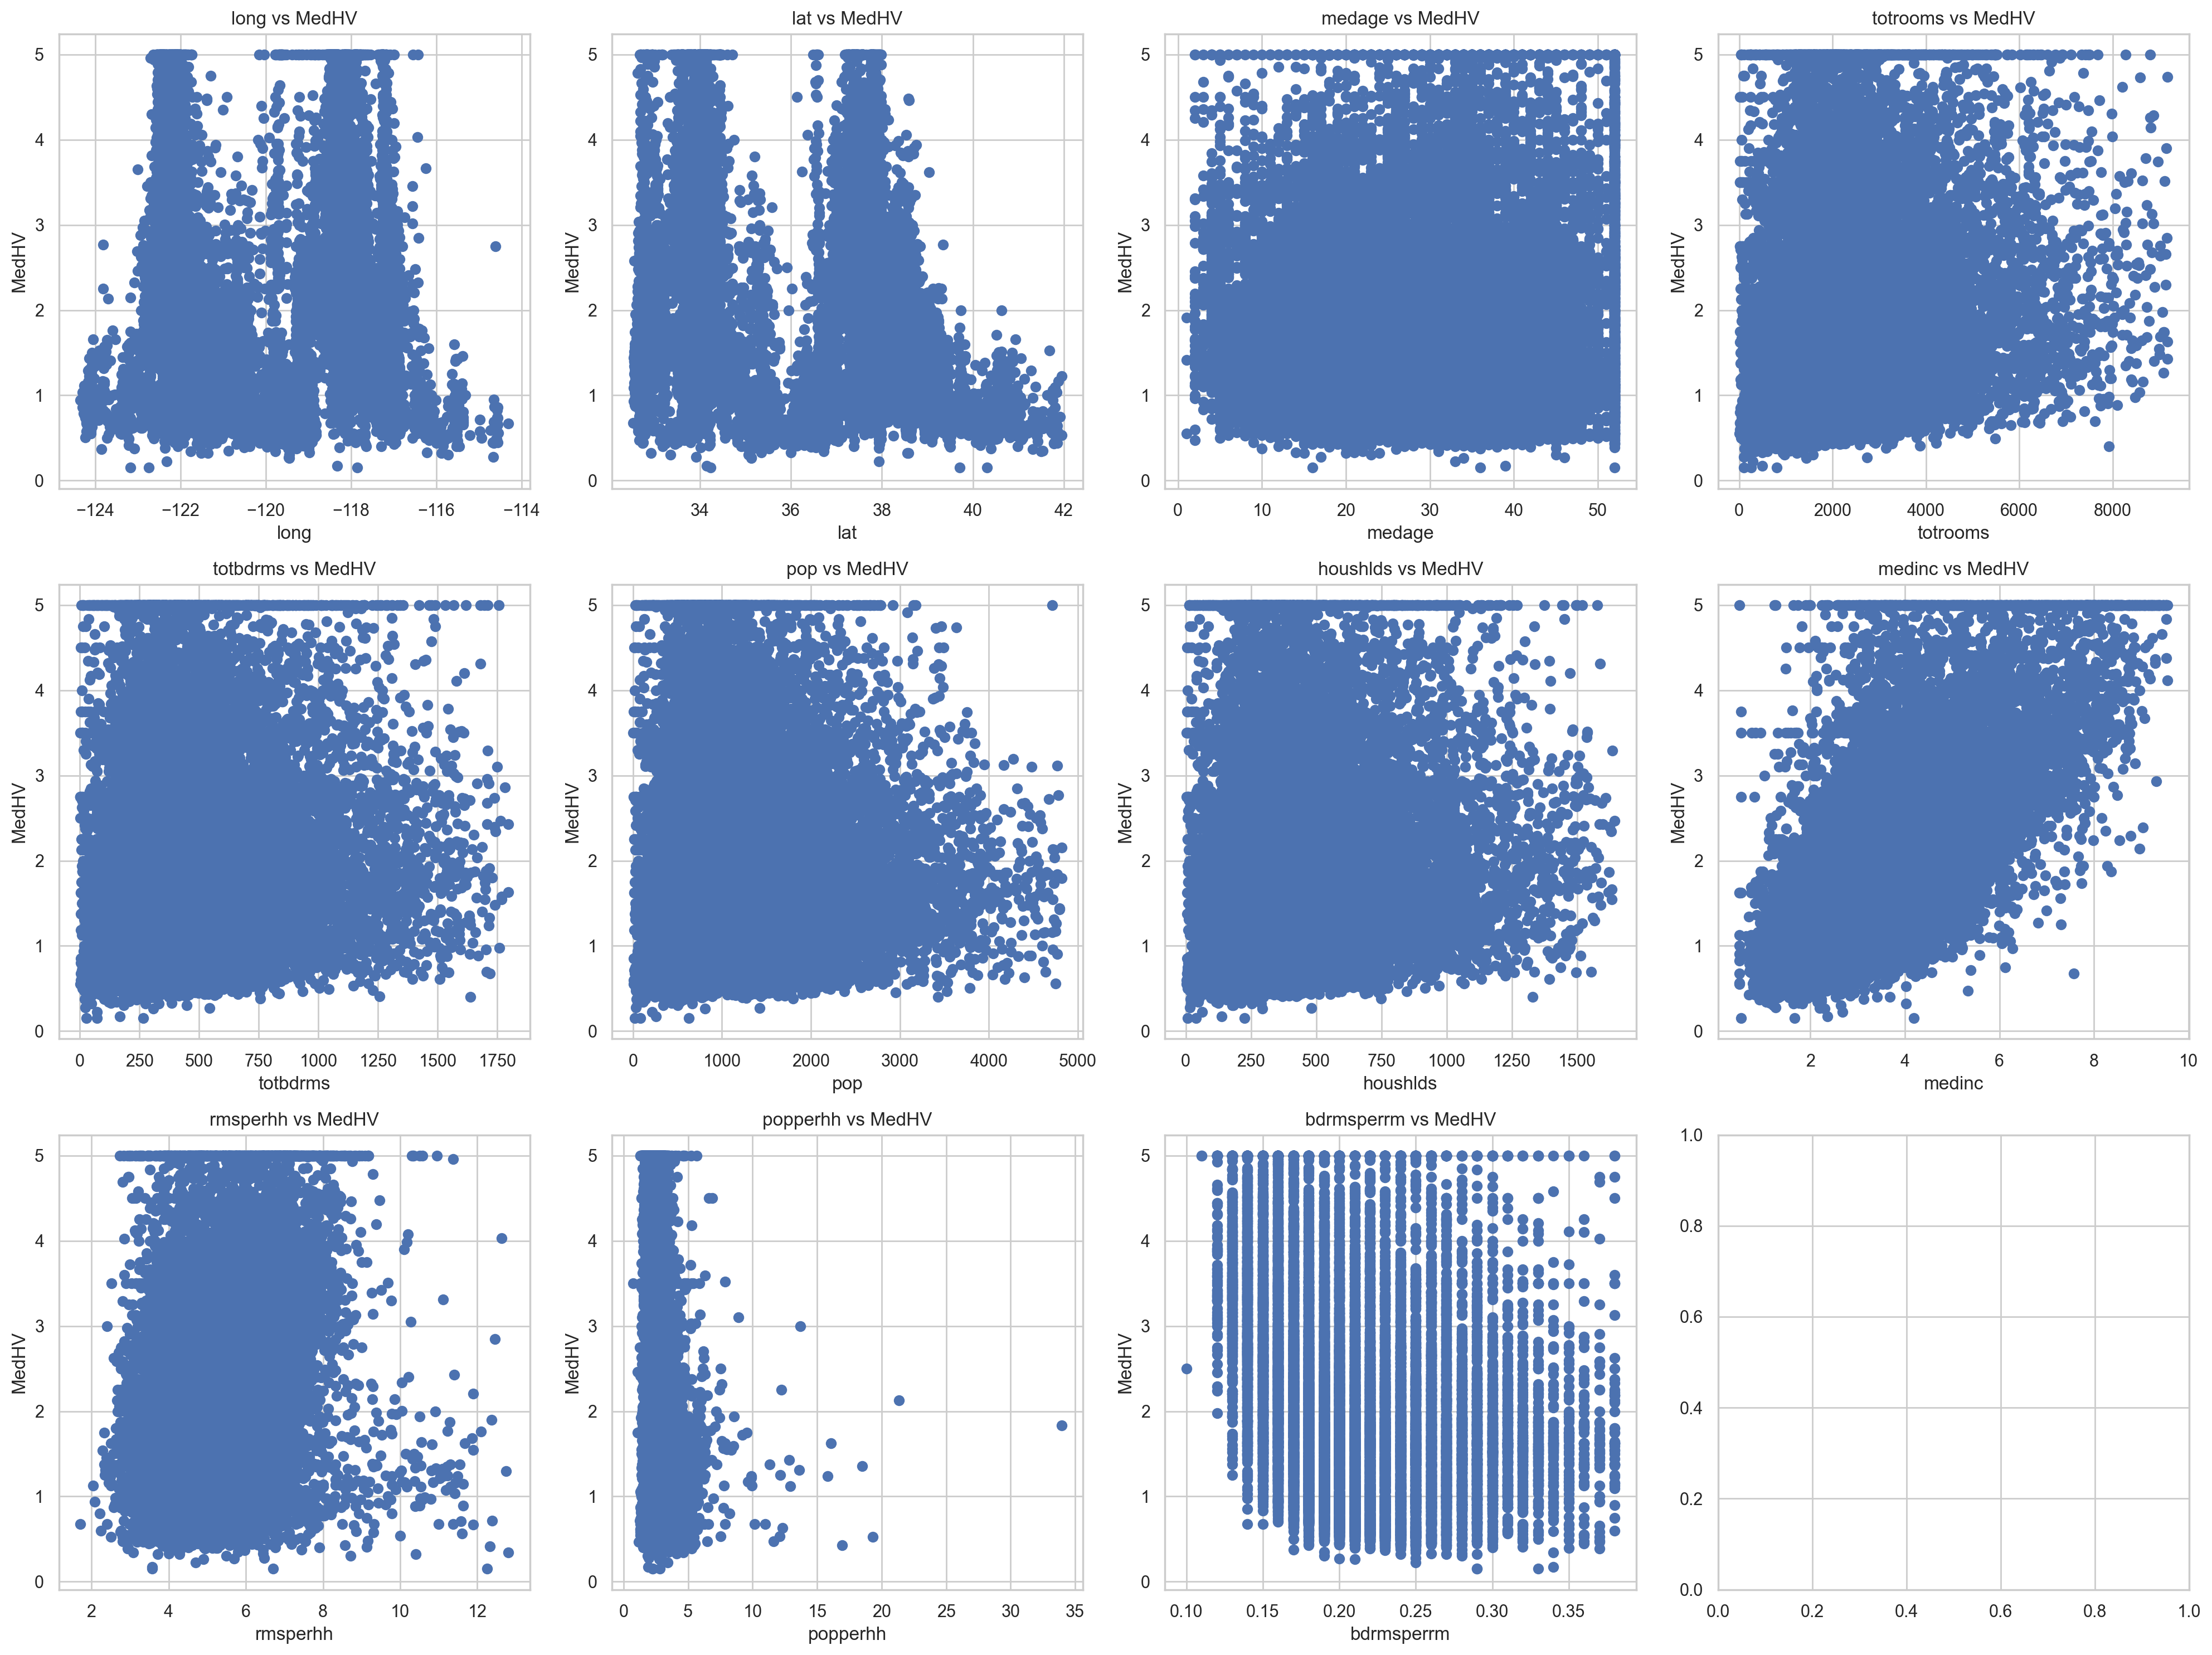

In [26]:
features = ['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']
pandas_df = filtered_df.toPandas()
fig, axes = plt.subplots(3, 4, figsize=(20, 15))


for i, feature in enumerate(features):

    row = i // 4
    col = i % 4
    

    axes[row, col].scatter(pandas_df[feature], pandas_df['medhv'])
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('MedHV')
    axes[row, col].set_title(f'{feature} vs MedHV')


plt.tight_layout()


plt.show()

In [27]:
# Re-order and select columns
housing_df = filtered_df.select("medhv", 
                                "long",
                                "lat",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

In [28]:
featureCols = ["long","lat","totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

In [29]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [30]:
assembled_df = assembler.transform(housing_df)

In [31]:
assembled_df.show(10, truncate=False)

+-----+-------+-----+--------+------+--------+------+--------+--------+----------+---------------------------------------------------------------------------------------------+
|medhv|long   |lat  |totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                                                                     |
+-----+-------+-----+--------+------+--------+------+--------+--------+----------+---------------------------------------------------------------------------------------------+
|4.526|-122.23|37.88|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[-122.2300033569336,37.880001068115234,129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|-122.22|37.86|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[-122.22000122070312,37.86000061035156,1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|-122.24|37.85|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[-122.23999786376953,37.849998474

In [32]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [33]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [34]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                     |features_scaled                                                                                                                                                            |
+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-122.2300033569336,37.880001068115234,129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[-60.90610741439747,17.68163433113657,0.4464946581226299,0.42035756994254647,0.47403042562881365,5.22

In [35]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

In [36]:
train_data.columns

['medhv',
 'long',
 'lat',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

In [37]:
# Initialize `lr`
# maxIters: This parameter determines the maximum number of times an algorithm can run before stopping the search for the best model.
# If the algorithm does not find the best solution within this number of iterations, it will cease.
maxIters = [10, 50, 100]

#regParams: This parameter controls the strength of regularization, which is a method to reduce the complexity of the model and prevent overfitting. 
# The higher the value of regParams, the stronger the regularization, which tends to make the model's parameters smaller.
regParams = [0, 0.01, 0.1, 0.5, 1]

# elasticNetParams: This parameter balances the use of L1 and L2 regularization.
# L1 regularization can result in sparse solutions (many parameters being zero), 
# while L2 regularization tends to keep parameter values close to zero but usually not exactly zero. 
# The value of elasticNetParams determines whether to use more L1 regularization (values closer to 1) or L2 regularization (values closer to 0).
elasticNetParams = [0, 0.3, 0.6, 1]

best_RMSE = [float('inf'),0,0,0]
best_MAE = [float('inf'),0,0,0]
best_R2 = [float('-inf'),0,0,0]
for maxIter in maxIters:
    for regParma in regParams:
        for elasticNetParam in elasticNetParams:
            lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='lr_predmedhv', 
                                        maxIter=maxIter, regParam=regParma, elasticNetParam=elasticNetParam, standardization=False))
            # Fit the data to the LRmodel
            linearModel = lr.fit(train_data)
            # Generate predictions
            lr_predictions = linearModel.transform(test_data)
            
            if best_RMSE[0] > linearModel.summary.rootMeanSquaredError:
                best_RMSE = [linearModel.summary.rootMeanSquaredError,maxIter,regParma,elasticNetParam]
                
            if best_MAE[0] > linearModel.summary.meanAbsoluteError:
                best_MAE = [linearModel.summary.meanAbsoluteError,maxIter,regParma,elasticNetParam]
                
            if best_R2[0] < linearModel.summary.r2:
                best_R2 = [linearModel.summary.r2,maxIter,regParma,elasticNetParam]
print("Best_RMSE:",best_RMSE[0],", maxIter:",best_RMSE[1],", regParma:",best_RMSE[2],", elasticNetParam:",best_RMSE[3])
print("Best_MAE:",best_MAE[0],", maxIter:",best_MAE[1],", regParma:",best_MAE[2],", elasticNetParam:",best_MAE[3])
print("Best_R2:",best_R2[0],", maxIter:",best_R2[1],", regParma:",best_R2[2],", elasticNetParam:",best_R2[3])
            

24/04/27 16:55:53 WARN Instrumentation: [cc359345] regParam is zero, which might cause numerical instability and overfitting.
24/04/27 16:55:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/27 16:55:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/04/27 16:55:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/04/27 16:55:54 WARN Instrumentation: [018e1bff] regParam is zero, which might cause numerical instability and overfitting.
24/04/27 16:55:55 WARN Instrumentation: [139f9d71] regParam is zero, which might cause numerical instability and overfitting.
24/04/27 16:55:55 WARN Instrumentation: [8aea6839] regParam is zero, which might cause numerical instability and overfitting.
24/04/27 16:56:02 WARN Instrumentation: [c638434e] regParam is zero, which might cause numerical instability and overfitting.
24/04/27 16:56:03 WARN Instrumentation: [3

Best_RMSE: 0.6665965526590685 , maxIter: 10 , regParma: 0 , elasticNetParam: 0
Best_MAE: 0.4861278540112904 , maxIter: 10 , regParma: 0.01 , elasticNetParam: 0
Best_R2: 0.6374188348292419 , maxIter: 10 , regParma: 0 , elasticNetParam: 0


In [38]:
# Initialize `rf`
# maxDepths (Maximum Depth): This parameter specifies the maximum depth for each tree in the forest. 
# The depth of a tree determines the number of splits in a decision tree. 
# Limiting the depth can reduce the risk of overfitting but may also increase the risk of underfitting. 
# Smaller values result in shallower trees, while larger values result in deeper trees.
maxDepths = [3, 5, 7, 10]

# numTrees (Number of Trees):This parameter determines the number of decision trees in the random forest.
# Increasing the number of trees can improve the model's performance because it increases the diversity of the model and the reliability of the voting. 
# However, too many trees can increase computational costs and lead to slow convergence. 
# Typically, a balance needs to be found to ensure there are enough trees for stable results without making the computation process too time-consuming.
numTreeses = [20,30,40,50]

# In some implementations, this parameter refers to the number of bins used to discretize continuous features when building decision trees. 
# Bins are used to segment continuous values into multiple intervals, which can simplify the decision-making process and reduce computational effort. 
# Smaller values mean finer granularity, which can lead to a more complex model and a higher risk of overfitting; 
# larger values mean coarser granularity, which can lead to a simpler model but may fail to capture all the details of the data.
maxBins = [8,16,32]

best_RMSE = [float('inf'),0,0,0]
best_MAE = [float('inf'),0,0,0]
best_R2 = [float('-inf'),0,0,0]
for maxDepth in maxDepths:
    for numTrees in numTreeses:
        for maxBin in maxBins:
            rf = (RandomForestRegressor(featuresCol='features_scaled', labelCol="medhv", predictionCol='rf_predmedhv', 
                                        maxDepth=maxDepth, numTrees = numTrees,maxBins = maxBin))
            # Fit the data to the RFmodel
            rfModel = rf.fit(train_data)
            # Generate predictions
            rf_predictions = rfModel.transform(test_data)
            evaluator = RegressionEvaluator(predictionCol="rf_predmedhv", labelCol='medhv', metricName='rmse')
            rmse = evaluator.evaluate(rf_predictions)
            if best_RMSE[0] > rmse:
                best_RMSE = [rmse,maxDepth,numTrees,maxBin]
                
            evaluator = RegressionEvaluator(predictionCol="rf_predmedhv", labelCol='medhv', metricName='mae')
            mae = evaluator.evaluate(rf_predictions)
            if best_MAE[0] > mae:
                best_MAE = [mae,maxDepth,numTrees,maxBin]

            evaluator = RegressionEvaluator(predictionCol="rf_predmedhv", labelCol='medhv', metricName='r2')
            r2 = evaluator.evaluate(rf_predictions)
            if best_R2[0] < r2:
                best_R2 = [r2,maxDepth,numTrees,maxBin]

print("Best_RMSE:",best_RMSE[0],", maxDepths:",best_RMSE[1],", numTrees:",best_RMSE[2],", maxBins:",best_RMSE[3])
print("Best_MAE:",best_MAE[0],", maxDepths:",best_MAE[1],", numTrees:",best_MAE[2],", maxBins:",best_MAE[3])
print("Best_R2:",best_R2[0],", maxDepths:",best_R2[1],", numTrees:",best_R2[2],", maxBins:",best_R2[3])
            

24/04/27 16:57:02 WARN DAGScheduler: Broadcasting large task binary with size 1047.8 KiB
24/04/27 16:57:05 WARN DAGScheduler: Broadcasting large task binary with size 1052.1 KiB
24/04/27 16:57:07 WARN DAGScheduler: Broadcasting large task binary with size 1057.3 KiB
24/04/27 16:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1491.5 KiB
24/04/27 16:57:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/04/27 16:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1502.9 KiB
24/04/27 16:57:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/04/27 16:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1500.3 KiB
24/04/27 16:57:15 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/04/27 16:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1223.2 KiB
24/04/27 16:57:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/04/27 16:57:18 WARN DAGSchedul

Best_RMSE: 0.56209533627301 , maxDepths: 10 , numTrees: 50 , maxBins: 32
Best_MAE: 0.39132315272556734 , maxDepths: 10 , numTrees: 50 , maxBins: 32
Best_R2: 0.7435871773017696 , maxDepths: 10 , numTrees: 50 , maxBins: 32


DeepLearning

In [39]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [40]:
print(scaled_df)

DataFrame[medhv: double, long: float, lat: float, totbdrms: float, pop: float, houshlds: float, medinc: float, rmsperhh: double, popperhh: double, bdrmsperrm: double, features: vector, features_scaled: vector]


In [41]:
features_columns = ['long','lat','totbdrms', 'pop', 'houshdls', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']
label_columns = ['medhv']

In [42]:
scaled_df.columns

['medhv',
 'long',
 'lat',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

In [43]:
features_df = scaled_df.select("features_scaled")
# convert to NumPy
features_np = features_df.rdd.map(lambda x: x['features_scaled']).collect()
features_np = np.array(features_np, dtype=np.float32)

# convert to PyTorch Tensor
features_tensor = torch.tensor(features_np)


In [44]:
labels_df = scaled_df.select("medhv")
# convert to NumPy
labels_np = labels_df.rdd.map(lambda x: x['medhv']).collect()
labels_np = np.array(labels_np, dtype=np.float32)

# convert to PyTorch Tensor
labels_tensor = torch.tensor(labels_np)

In [45]:
features_tensor
labels_tensor
features_tensor.shape
labels_tensor.shape

tensor([[-60.9061,  17.6816,   0.4465,  ...,   5.8901,   2.9538,   3.1638],
        [-60.9011,  17.6723,   3.8281,  ...,   5.2656,   2.4345,   3.3748],
        [-60.9111,  17.6676,   0.6576,  ...,   6.9955,   3.2307,   2.7420],
        ...,
        [-60.4028,  18.4051,   1.6787,  ...,   4.3965,   2.6884,   4.6403],
        [-60.4527,  18.4051,   1.4156,  ...,   4.4977,   2.4461,   4.6403],
        [-60.4128,  18.3771,   2.1321,  ...,   4.4302,   3.0230,   4.6403]])

tensor([4.5260, 3.5850, 3.5210,  ..., 0.9230, 0.8470, 0.8940])

torch.Size([19343, 9])

torch.Size([19343])

In [46]:
class PriceDataset(Dataset):
    def __init__(self, data,label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [47]:
dataset = PriceDataset(features_tensor,labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [48]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
# define a full connection network
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        return x

In [50]:
model = FullyConnectedNet()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)

# train
def train():
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.unsqueeze(1)
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_loss /= len(train_loader.dataset)  
    print(f'Train Loss: {train_loss:.4f}',end="  ")
# test
def test():
    model.eval()
    test_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            target = target.unsqueeze(1)
            output = model(data)
            test_loss += criterion(output, target).item()
            predictions.extend(output.cpu().detach().numpy().flatten())
            targets.extend(target.cpu().detach().numpy())

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}', end="  ")

    # convert predictions and targets to Tensor
    predictions_tensor = torch.tensor(predictions)
    targets_tensor = torch.tensor(np.array(targets)).squeeze(1)
    # calculate RMSE
    rmse = torch.sqrt(torch.mean((predictions_tensor - targets_tensor) ** 2))
    print(f'RMSE: {rmse.item():.4f}', end="  ")

    # calculate MAE
    mae = mean_absolute_error(targets, predictions)
    print(f'MAE: {mae:.4f}', end="  ")

    # calculate R²
    r2 = r2_score(targets, predictions)
    print(f'R²: {r2:.4f}')
    return rmse,mae,r2



In [51]:
best_RMSE = float('inf')
best_MAE = float('inf')
best_R2 = float('-inf')
for i in range(100):
    print("epoch:",i+1,end='   ')
    train()
    rmse,mae,r2 = test()
    if best_RMSE > rmse:
        best_RMSE = rmse
    if best_MAE > mae:
        best_MAE = mae
    if best_R2 < r2:
        best_R2 = r2
print("best_RMSE:",best_RMSE.item(),", best_MAE:",best_MAE,", best_R2",best_R2)

epoch: 1   Train Loss: 0.0185  Test Loss: 0.0134  RMSE: 0.9249  MAE: 0.7175  R²: 0.2815
epoch: 2   Train Loss: 0.0112  Test Loss: 0.0089  RMSE: 0.7508  MAE: 0.5708  R²: 0.5266
epoch: 3   Train Loss: 0.0086  Test Loss: 0.0078  RMSE: 0.7049  MAE: 0.5297  R²: 0.5826
epoch: 4   Train Loss: 0.0083  Test Loss: 0.0080  RMSE: 0.7131  MAE: 0.5536  R²: 0.5729
epoch: 5   Train Loss: 0.0081  Test Loss: 0.0079  RMSE: 0.7085  MAE: 0.5479  R²: 0.5784
epoch: 6   Train Loss: 0.0080  Test Loss: 0.0078  RMSE: 0.7028  MAE: 0.5390  R²: 0.5852
epoch: 7   Train Loss: 0.0079  Test Loss: 0.0076  RMSE: 0.6956  MAE: 0.5278  R²: 0.5937
epoch: 8   Train Loss: 0.0079  Test Loss: 0.0075  RMSE: 0.6928  MAE: 0.5241  R²: 0.5968
epoch: 9   Train Loss: 0.0078  Test Loss: 0.0074  RMSE: 0.6860  MAE: 0.5059  R²: 0.6047
epoch: 10   Train Loss: 0.0079  Test Loss: 0.0074  RMSE: 0.6860  MAE: 0.5093  R²: 0.6047
epoch: 11   Train Loss: 0.0078  Test Loss: 0.0077  RMSE: 0.7014  MAE: 0.5313  R²: 0.5868
epoch: 12   Train Loss: 0.0078

In [52]:
# spark.stop()